
**Task 1: Baseline EvaluationWe evaluated the top-1 and top-5 accuracy of a pretrained ResNet-34 model on the clean test dataset (ImageNet-1K subset, 100 classes). The model was normalized using standard ImageNet mean and std values.**


Results:

    Top-1 Accuracy: 76.00%

    Top-5 Accuracy: 94.20%

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
import os

# Preprocessing for ImageNet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Paths
dataset_path = "/kaggle/input/datasetfordl/TestDataSet"
json_path = os.path.join(dataset_path, "labels_list.json")

# Load label list
with open(json_path, 'r') as f:
    label_lines = json.load(f)

imagenet_labels = [int(line.split(":")[0]) for line in label_lines]

# Load dataset
image_folder_dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# Sanity check
if len(imagenet_labels) != len(image_folder_dataset.classes):
    raise ValueError("Mismatch between number of folders and labels in labels_list.json")

# Map: folder index -> true ImageNet class index
idx_to_imagenet = {i: imagenet_labels[i] for i in range(len(imagenet_labels))}

# Debug: Print a few mappings
print("Sample folder-to-label mappings:")
for i in range(min(3, len(idx_to_imagenet))):
    print(f"  Folder index {i} → ImageNet class index {idx_to_imagenet[i]}")

# Custom Dataset with true labels
class CorrectedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, idx_to_imagenet_label):
        self.base_dataset = base_dataset
        self.idx_to_imagenet_label = idx_to_imagenet_label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, folder_idx = self.base_dataset[idx]
        true_label = self.idx_to_imagenet_label[folder_idx]
        return image, int(true_label)

# Wrap dataset
corrected_dataset = CorrectedLabelDataset(image_folder_dataset, idx_to_imagenet)
test_loader = DataLoader(corrected_dataset, batch_size=32, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# Top-k accuracy function
def topk_accuracy(output, target, topk=(1, 5)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum()) for k in topk]

# Evaluate
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
        top1_correct += top1
        top5_correct += top5
        total += labels.size(0)

        if total % 320 == 0:
            print(f"[{total} samples] Top-1: {100 * top1_correct / total:.2f}%, Top-5: {100 * top5_correct / total:.2f}%")

# Final result
print(f"✅ Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"✅ Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


Sample folder-to-label mappings:
  Folder index 0 → ImageNet class index 401
  Folder index 1 → ImageNet class index 402
  Folder index 2 → ImageNet class index 403


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s] 
 62%|██████▎   | 10/16 [00:05<00:02,  2.72it/s]

[320 samples] Top-1: 77.19%, Top-5: 95.62%


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

✅ Top-1 Accuracy: 76.00%
✅ Top-5 Accuracy: 94.20%


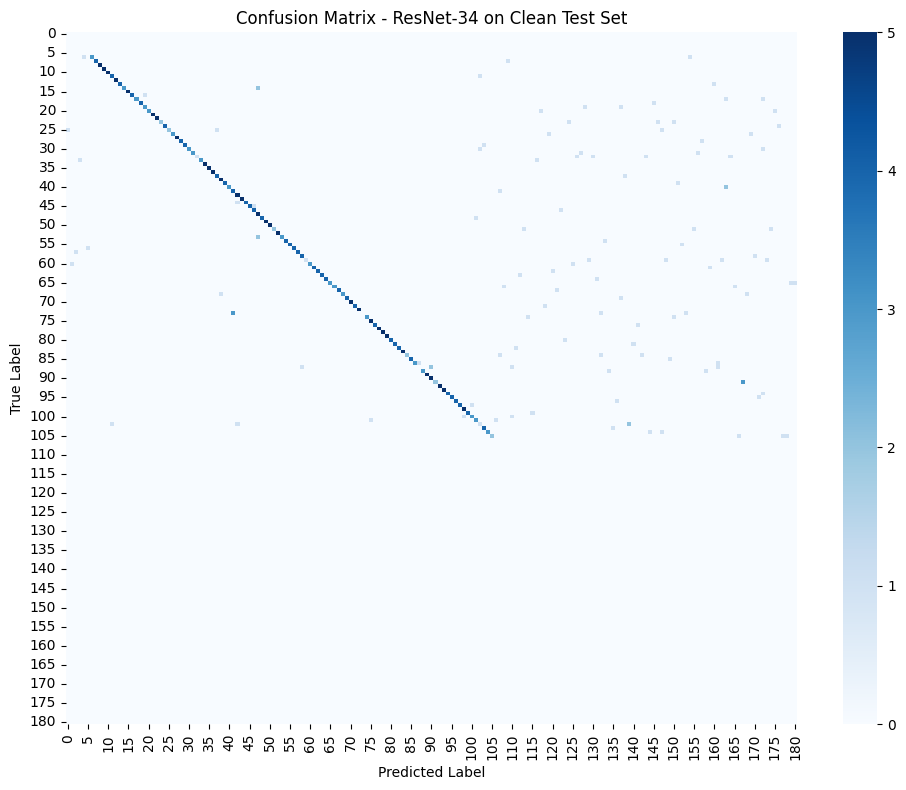

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet-34 on Clean Test Set")
plt.tight_layout()
plt.savefig("figures/confusion_matrix_clean.png", dpi=300)
plt.show()

In [4]:
json_path = os.path.join(dataset_path, "labels_list.json")

# Load and validate structure
with open(json_path, 'r') as f:
    label_list = json.load(f)

# Sanity check
if not isinstance(label_list, list) or ":" not in label_list[0]:
    raise ValueError("Unexpected format in labels_list.json. Expected list of 'index: label' strings.")

# Show a preview
print("Loaded label list sample:")
for entry in label_list[:5]:
    print(f"  {entry}")


Loaded label list sample:
  401: accordion
  402: acoustic guitar
  403: aircraft carrier
  404: airliner
  405: airship



**Task 2: FGSM (Pixel-wise Attack)We implemented the Fast Gradient Sign Method (FGSM) using an L∞-bounded perturbation with ε = 0.02. Perturbations were applied across the full image. Adversarial examples were visually imperceptible but caused significant misclassification.Adversarial Test Set 1 was saved and evaluated.**


Results:

    Top-1 Accuracy: 3.40%

    Top-5 Accuracy: 21.20%

We visualized 3–5 adversarial examples along with the original image, perturbation, and prediction bar chart.

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as vutils
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os

# ImageNet normalization parameters
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

# Custom utility functions for normalization adjustments
def to_pixel_space(tensor, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

def to_normalized_space(tensor, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
    return (tensor - mean) / std

# Assume test_loader is already defined from Task 1
# Also assume model and topk_accuracy function are available

# Setup
epsilon = 0.02
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Directory to save adversarial images
adv_dir = "/content/Adversarial_Test_Set_1"
os.makedirs(adv_dir, exist_ok=True)

# Buffers to store adversarial examples and true labels
adv_examples = []
true_targets = []

# Generate FGSM adversarial examples
for batch_idx, (images, targets) in enumerate(tqdm(test_loader)):
    images, targets = images.to(device), targets.to(device)
    images = images.clone().detach().requires_grad_(True)

    outputs = model(images)
    loss = loss_fn(outputs, targets)

    model.zero_grad()
    loss.backward()
    gradients = images.grad.data

    # Move to pixel space for perturbation
    pixel_images = to_pixel_space(images, mean_vals, std_vals)
    pixel_adv = pixel_images + epsilon * gradients.sign()
    pixel_adv = torch.clamp(pixel_adv, 0, 1)

    # Convert back to normalized space
    norm_adv = to_normalized_space(pixel_adv, mean_vals, std_vals)

    # Store for evaluation
    adv_examples.append(norm_adv.detach().cpu())
    true_targets.append(targets.detach().cpu())

    # Save visuals
    for j in range(images.size(0)):
        img = pixel_adv[j].detach().cpu()
        vutils.save_image(img, os.path.join(adv_dir, f"img_{batch_idx * 32 + j}.png"))

# Build evaluation loader
X_adv = torch.cat(adv_examples).float()
Y_adv = torch.cat(true_targets)
adv_loader = DataLoader(TensorDataset(X_adv, Y_adv), batch_size=32, shuffle=False)

# Evaluation
correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(adv_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
        correct_top1 += top1
        correct_top5 += top5
        total += labels.size(0)

        # Optional progress logging
        if total % 320 == 0:
            print(f"[{total} samples] Adv Top-1: {100 * correct_top1 / total:.2f}%, Top-5: {100 * correct_top5 / total:.2f}%")

# Final output
print("\n📌 FGSM Adversarial Attack Summary (ε = 0.02)")
print(f"Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
print(f"Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")


 75%|███████▌  | 12/16 [00:00<00:00, 19.64it/s]

[320 samples] Adv Top-1: 4.69%, Top-5: 24.06%


100%|██████████| 16/16 [00:00<00:00, 19.84it/s]


📌 FGSM Adversarial Attack Summary (ε = 0.02)
Top-1 Accuracy: 3.40%
Top-5 Accuracy: 21.20%


True: bathing cap | Predicted: Class 775


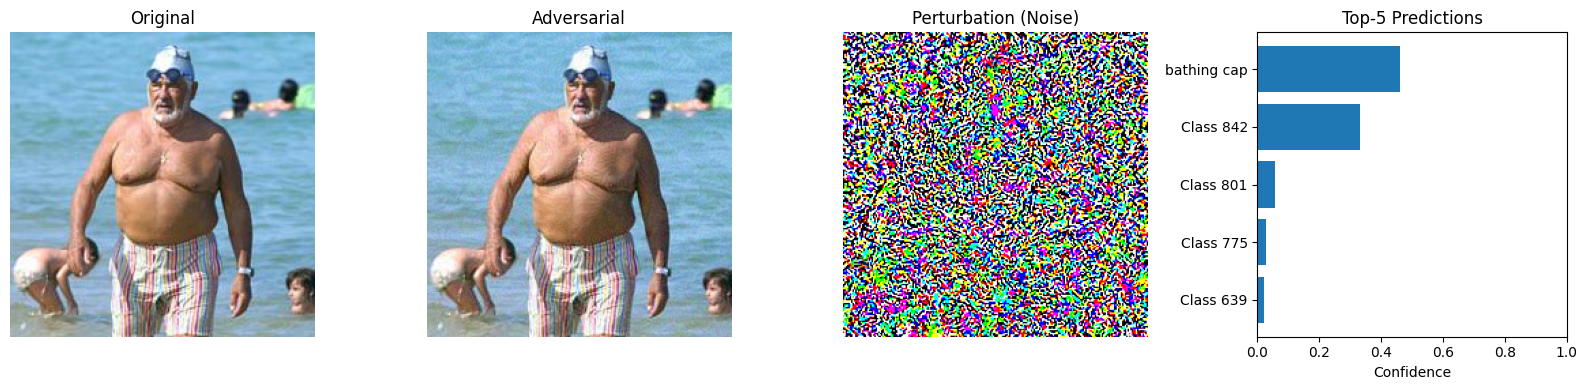

True: bathing cap | Predicted: Class 6


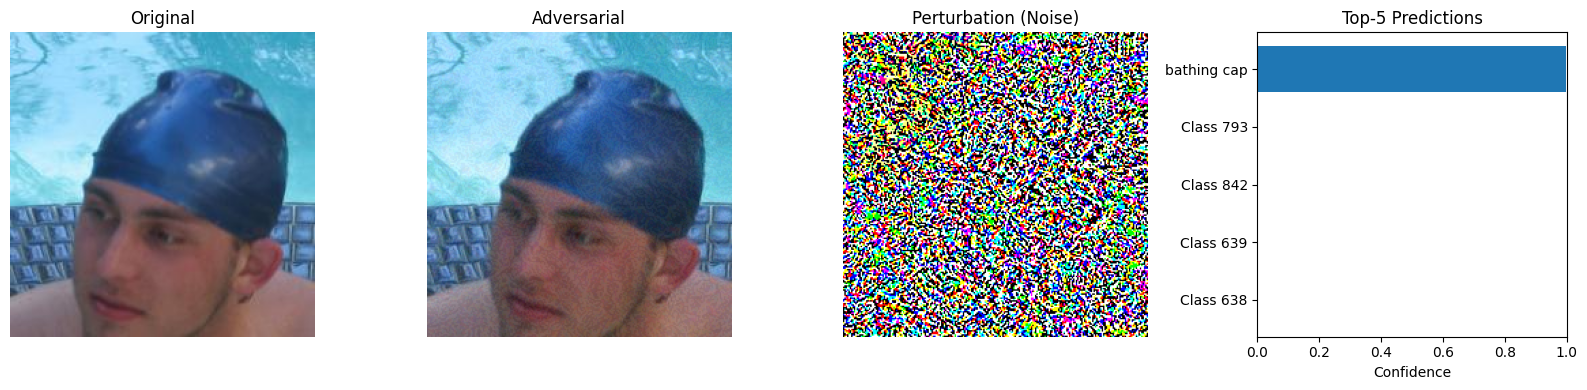

True: bathing cap | Predicted: Class 903


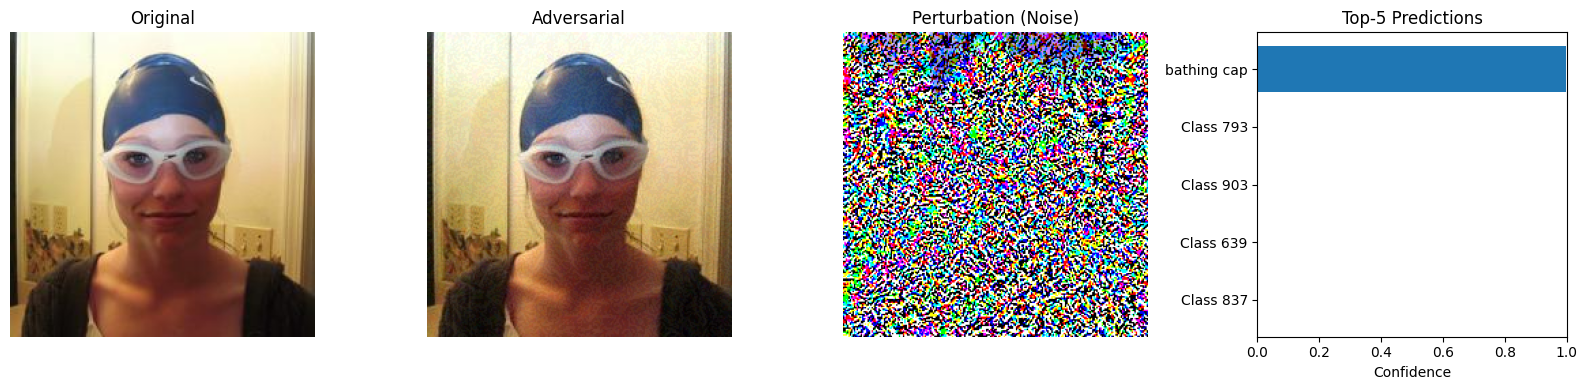

True: bathing cap | Predicted: Class 639


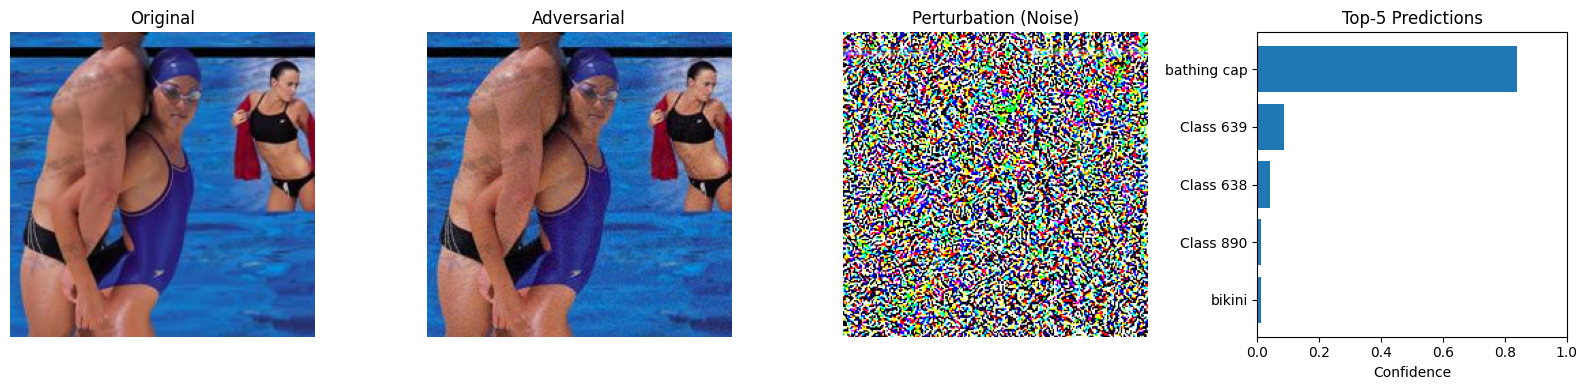

True: bathing cap | Predicted: Class 81


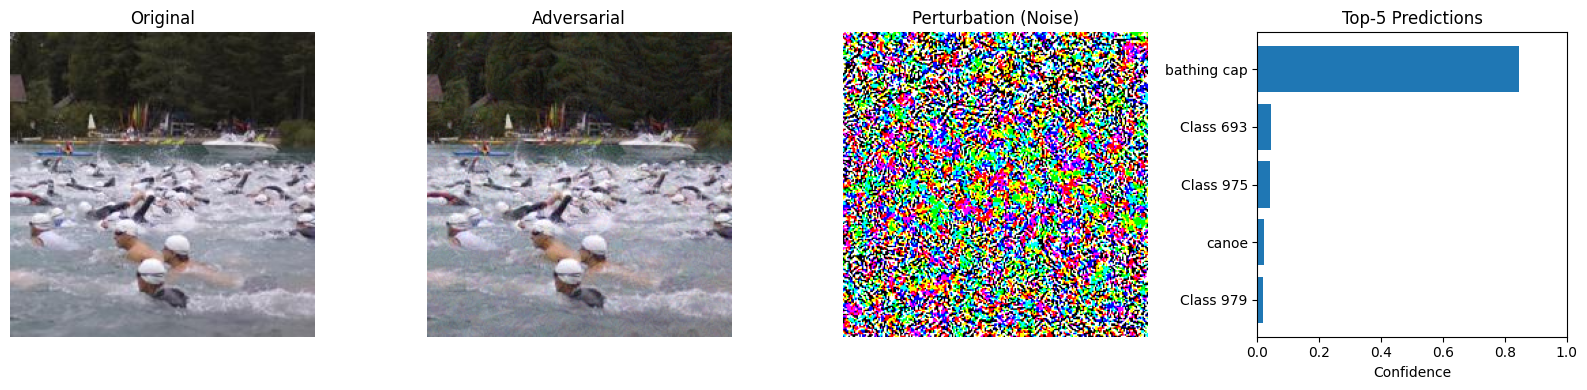

In [6]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# Load class names
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    class_names = [line.split(":")[1].strip() for line in json.load(f)]

# Unnormalize image for display
def display_pixel_img(tensor):
    return to_pixel_space(tensor.unsqueeze(0), mean_vals, std_vals).squeeze(0)

shown = 0
max_to_show = 5
skip_batches = 5  # skip first few batches to show different examples

for batch_num, (images, labels) in enumerate(test_loader):
    if batch_num < skip_batches:
        continue

    images, labels = images.to(device), labels.to(device)
    images = images.clone().detach().requires_grad_(True)

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    grad = images.grad.data
    pixel_images = to_pixel_space(images, mean_vals, std_vals)
    perturbed_pixel = torch.clamp(pixel_images + epsilon * grad.sign(), 0, 1)
    perturbed_norm = to_normalized_space(perturbed_pixel, mean_vals, std_vals).float()

    with torch.no_grad():
        preds = model(perturbed_norm).argmax(dim=1)

    for i in range(images.size(0)):
        if preds[i].item() != labels[i].item():
            # Prepare components
            original_img = display_pixel_img(images[i].detach().cpu()).permute(1, 2, 0)
            adversarial_img = perturbed_pixel[i].detach().cpu().permute(1, 2, 0)
            noise = (perturbed_pixel[i] - pixel_images[i]).detach().cpu()
            noise = (noise - noise.min()) / (noise.max() - noise.min())  # normalize to [0,1]
            noise_img = noise.permute(1, 2, 0)

            # Prediction bar chart (top-5)
            with torch.no_grad():
                prob = F.softmax(outputs[i], dim=0)
                top5_vals, top5_idxs = torch.topk(prob, 5)
                top5_probs = top5_vals.cpu().numpy()
                top5_labels = [
                    class_names[idx.item() - 401] if 401 <= idx.item() <= 500 else f"Class {idx.item()}"
                    for idx in top5_idxs
                ]

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            # Original
            axes[0].imshow(original_img)
            axes[0].set_title("Original")
            axes[0].axis('off')

            # Adversarial
            axes[1].imshow(adversarial_img)
            axes[1].set_title("Adversarial")
            axes[1].axis('off')

            # Noise
            axes[2].imshow(noise_img)
            axes[2].set_title("Perturbation (Noise)")
            axes[2].axis('off')

            # Predictions
            axes[3].barh(top5_labels[::-1], top5_probs[::-1])
            axes[3].set_xlim(0, 1)
            axes[3].set_title("Top-5 Predictions")
            axes[3].set_xlabel("Confidence")

            # Label summary
            true_id = labels[i].item()
            pred_id = preds[i].item()
            true_label = class_names[true_id - 401] if 401 <= true_id <= 500 else f"Class {true_id}"
            pred_label = class_names[pred_id - 401] if 401 <= pred_id <= 500 else f"Class {pred_id}"
            print(f"True: {true_label} | Predicted: {pred_label}")

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= max_to_show:
                break
    if shown >= max_to_show:
        break


**Task 3: PGD (Improved Pixel-wise Attack)**

We extended FGSM into a Projected Gradient Descent (PGD) attack with:

    ε = 0.02

    α = 0.005

    10 steps

PGD degraded performance further while maintaining subtle perturbations.

Adversarial Test Set 2 was saved and evaluated.

Results:

    Top-1 Accuracy: 0.00%

    Top-5 Accuracy: 1.20%

Visuals confirm stronger misclassification with minimal visual distortion.

In [9]:
# PGD Parameters
pgd_eps = 0.02
pgd_alpha = 0.005
pgd_steps = 10
adv_dir_pgd = "/content/Adversarial Test Set 2"
os.makedirs(adv_dir_pgd, exist_ok=True)

adversarial_images_pgd = []
true_labels_pgd = []

# Generate PGD-based adversarial set
for i, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    images_unnorm = to_pixel_space(images, mean_vals, std_vals).clone().detach()
    images_adv = images_unnorm.clone().detach().requires_grad_(True)

    for step in range(pgd_steps):
        model.zero_grad()
        outputs = model(to_normalized_space(images_adv, mean_vals, std_vals).float())
        loss = loss_fn(outputs, labels)
        loss.backward()

        grad = images_adv.grad.data
        images_adv = images_adv + pgd_alpha * grad.sign()
        images_adv = torch.max(torch.min(images_adv, images_unnorm + pgd_eps), images_unnorm - pgd_eps)
        images_adv = torch.clamp(images_adv, 0, 1).detach().requires_grad_(True)

    final_adv = to_normalized_space(images_adv, mean_vals, std_vals).float()
    adversarial_images_pgd.append(final_adv.detach().cpu())
    true_labels_pgd.append(labels.detach().cpu())

    for j in range(images.size(0)):
        img = images_adv[j].detach().cpu()
        vutils.save_image(img, os.path.join(adv_dir_pgd, f"img_{i*32 + j}.png"))

# Build loader for evaluation
adv_tensor_pgd = torch.cat(adversarial_images_pgd).float()
label_tensor_pgd = torch.cat(true_labels_pgd)
adv_dataset_pgd = torch.utils.data.TensorDataset(adv_tensor_pgd, label_tensor_pgd)
adv_loader_pgd = DataLoader(adv_dataset_pgd, batch_size=32, shuffle=False)

# Evaluation
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(adv_loader_pgd):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
        top1_correct += top1
        top5_correct += top5
        total += labels.size(0)

print(f"\n📌 Task 3 - PGD ε={pgd_eps} (α={pgd_alpha}, steps={pgd_steps})")
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 18.38it/s]


📌 Task 3 - PGD ε=0.02 (α=0.005, steps=10)
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 1.20%


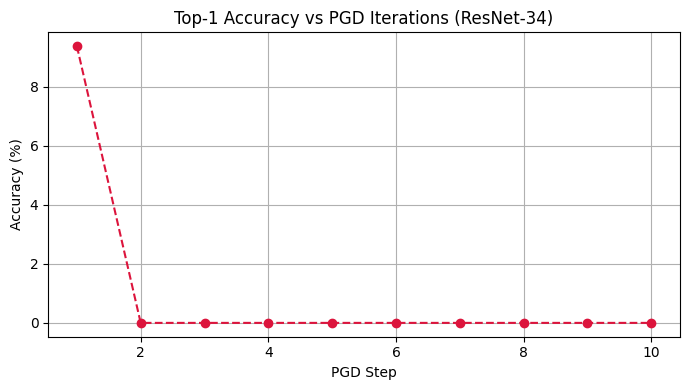

In [10]:
# PGD Step-wise Accuracy Drop Visualization
stepwise_acc = []
pgd_eps = 0.02
pgd_alpha = 0.005
pgd_steps = 10

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
x_nat = to_pixel_space(images, mean_vals, std_vals).detach()
x_adv = x_nat.clone().detach().requires_grad_(True)

for step in range(pgd_steps):
    model.zero_grad()
    outputs = model(to_normalized_space(x_adv, mean_vals, std_vals).float())
    loss = loss_fn(outputs, labels)
    loss.backward()

    grad = x_adv.grad.data
    x_adv = x_adv + pgd_alpha * grad.sign()
    x_adv = torch.max(torch.min(x_adv, x_nat + pgd_eps), x_nat - pgd_eps)
    x_adv = torch.clamp(x_adv, 0, 1).detach().requires_grad_(True)

    with torch.no_grad():
        preds = model(to_normalized_space(x_adv, mean_vals, std_vals).float()).argmax(dim=1)
        acc = (preds == labels).float().mean().item() * 100
        stepwise_acc.append(acc)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(range(1, pgd_steps + 1), stepwise_acc, marker='o', linestyle='--', color='crimson')
plt.title("Top-1 Accuracy vs PGD Iterations (ResNet-34)")
plt.xlabel("PGD Step")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/pgd_accuracy_drop.png", dpi=300)
plt.show()


True: bathing cap | Predicted: Class 775


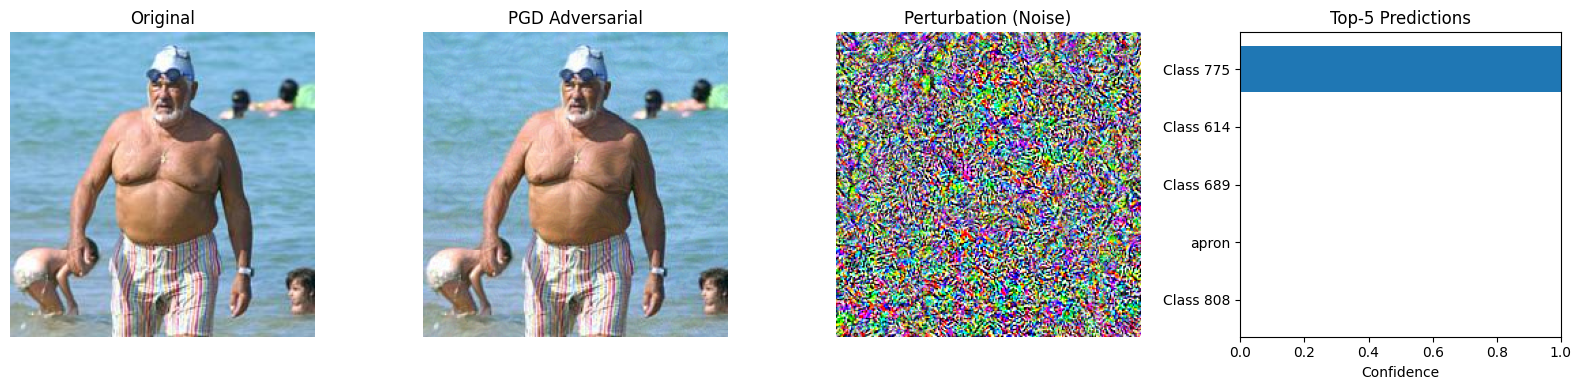

True: bathing cap | Predicted: Class 6


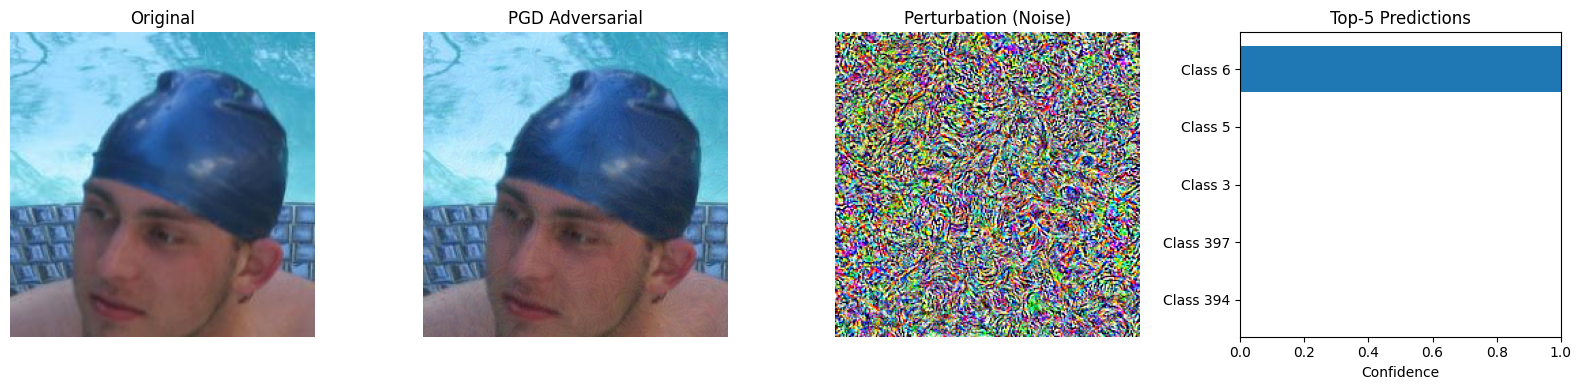

True: bathing cap | Predicted: Class 265


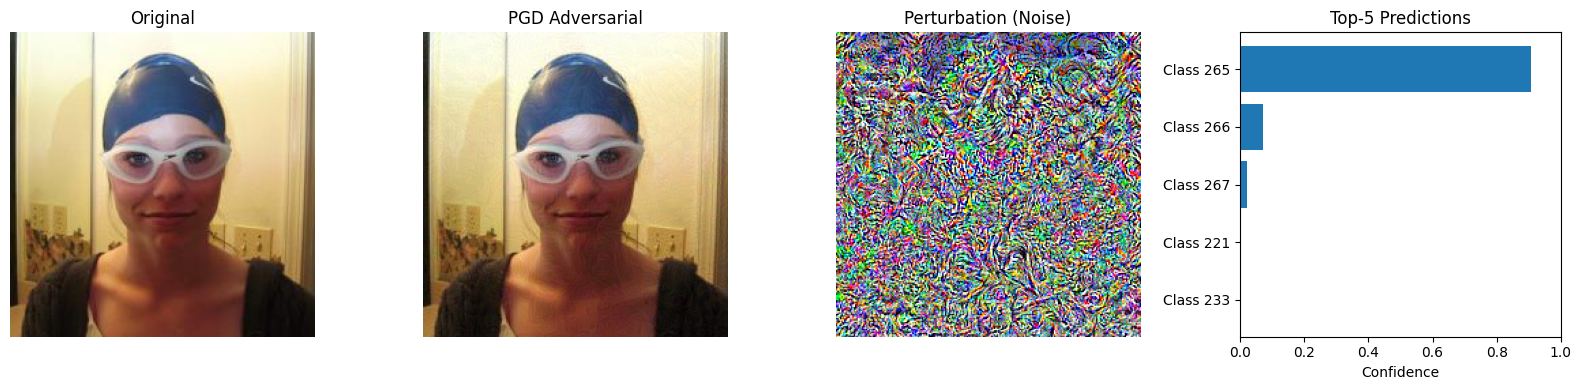

True: bathing cap | Predicted: Class 638


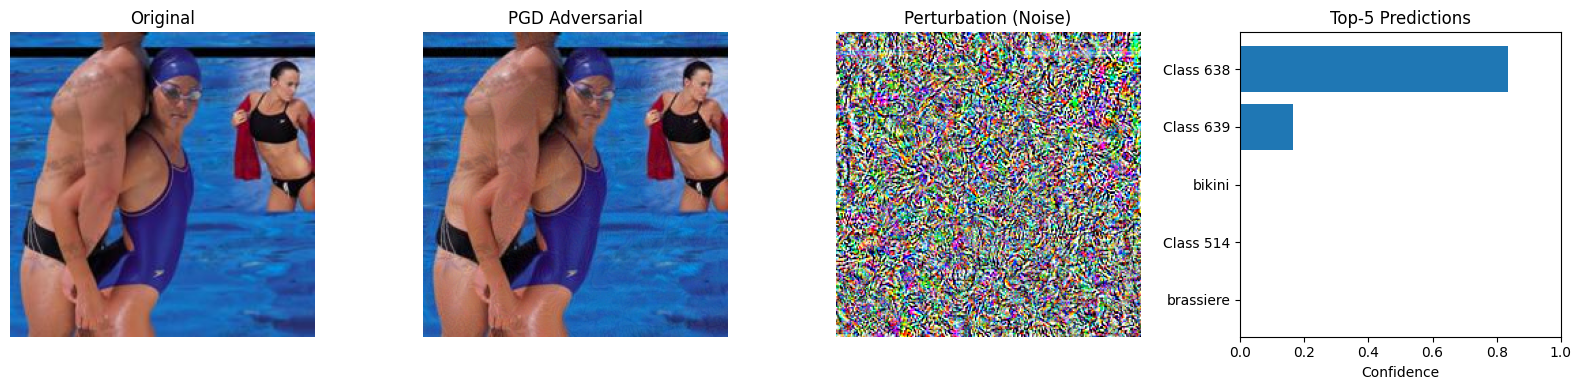

True: bathing cap | Predicted: Class 979


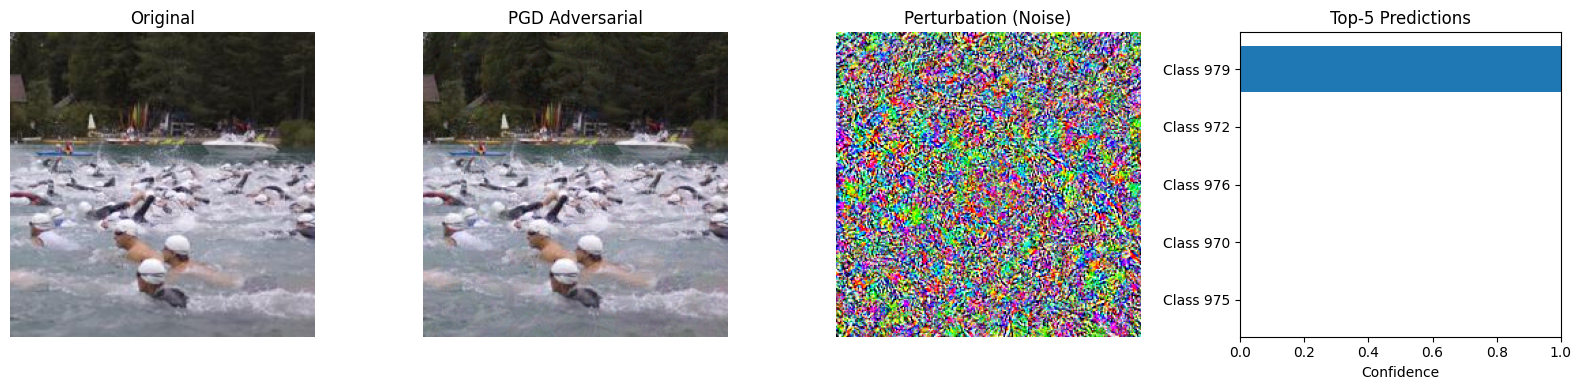

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

shown = 0
max_to_show = 5
skip_batches = 5

for batch_num, (images, labels) in enumerate(test_loader):
    if batch_num < skip_batches:
        continue

    images, labels = images.to(device), labels.to(device)
    pixel_images = to_pixel_space(images, mean_vals, std_vals).clone().detach()
    adv = pixel_images.clone().detach().requires_grad_(True)

    for step in range(pgd_steps):
        outputs = model(to_normalized_space(adv, mean_vals, std_vals).float())
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = adv.grad.data
        adv = adv + pgd_alpha * grad.sign()
        adv = torch.max(torch.min(adv, pixel_images + pgd_eps), pixel_images - pgd_eps)
        adv = torch.clamp(adv, 0, 1).detach().requires_grad_(True)

    adv_norm = to_normalized_space(adv, mean_vals, std_vals).float()
    with torch.no_grad():
        preds = model(adv_norm).argmax(dim=1)

    for i in range(images.size(0)):
        if preds[i].item() != labels[i].item():
            # Perturbation (Noise)
            noise = (adv[i].detach() - pixel_images[i]).cpu()
            noise = (noise - noise.min()) / (noise.max() - noise.min())
            noise_img = noise.permute(1, 2, 0)

            # Top-5 prediction bar chart
            with torch.no_grad():
                prob = F.softmax(model(adv_norm[i].unsqueeze(0)), dim=1)[0]
                top5_vals, top5_idxs = torch.topk(prob, 5)
                top5_probs = top5_vals.cpu().numpy()
                top5_labels = [
                    class_names[idx.item() - 401] if 401 <= idx.item() <= 500 else f"Class {idx.item()}"
                    for idx in top5_idxs
                ]

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(pixel_images[i].detach().cpu().permute(1, 2, 0))
            axes[0].set_title("Original")
            axes[0].axis('off')

            axes[1].imshow(adv[i].detach().cpu().permute(1, 2, 0))
            axes[1].set_title("PGD Adversarial")
            axes[1].axis('off')

            axes[2].imshow(noise_img)
            axes[2].set_title("Perturbation (Noise)")
            axes[2].axis('off')

            axes[3].barh(top5_labels[::-1], top5_probs[::-1])
            axes[3].set_xlim(0, 1)
            axes[3].set_title("Top-5 Predictions")
            axes[3].set_xlabel("Confidence")

            # Print mismatch
            true_id = labels[i].item()
            pred_id = preds[i].item()
            true_label = class_names[true_id - 401] if 401 <= true_id <= 500 else f"Class {true_id}"
            pred_label = class_names[pred_id - 401] if 401 <= pred_id <= 500 else f"Class {pred_id}"
            print(f"True: {true_label} | Predicted: {pred_label}")

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= max_to_show:
                break
    if shown >= max_to_show:
        break



**Task 4: Patch AttackWe attacked a 32×32 patch in each image (randomly placed) with larger ε = 0.5. A PGD-style update was used within the patch, leaving the rest of the image untouched.**


Adversarial Test Set 3 was saved and evaluated.

Results:

    Top-1 Accuracy: 28.60%

    Top-5 Accuracy: 68.40%

Despite localized perturbations, patch attacks led to misclassification in many cases.

In [12]:
patch_eps = 0.5
patch_alpha = 0.1
patch_size = 32
patch_steps = 10

adv_dir_patch = "/content/Adversarial Test Set 3"
os.makedirs(adv_dir_patch, exist_ok=True)

adversarial_images_patch = []
true_labels_patch = []

for i, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    pixel_images = to_pixel_space(images, mean_vals, std_vals).clone().detach()
    B, C, H, W = pixel_images.shape

    # Create random patch locations per image
    x_starts = torch.randint(0, H - patch_size, (B,))
    y_starts = torch.randint(0, W - patch_size, (B,))

    adv = pixel_images.clone().detach().requires_grad_(True)

    for step in range(patch_steps):
        model.zero_grad()
        outputs = model(to_normalized_space(adv, mean_vals, std_vals).float())
        loss = loss_fn(outputs, labels)
        loss.backward()
        grad = adv.grad.data

        perturb = torch.zeros_like(adv)

        # Apply patch perturbation for each image
        for b in range(B):
            x, y = x_starts[b], y_starts[b]
            patch_grad = grad[b, :, x:x+patch_size, y:y+patch_size].sign()
            perturb[b, :, x:x+patch_size, y:y+patch_size] = patch_alpha * patch_grad

        adv = adv + perturb
        adv = torch.max(torch.min(adv, pixel_images + patch_eps), pixel_images - patch_eps)
        adv = torch.clamp(adv, 0, 1).detach().requires_grad_(True)

    final_adv = to_normalized_space(adv, mean_vals, std_vals).float()
    adversarial_images_patch.append(final_adv.detach().cpu())
    true_labels_patch.append(labels.detach().cpu())

    for j in range(B):
        raw_img = adv[j].detach().cpu()
        vutils.save_image(raw_img, os.path.join(adv_dir_patch, f"img_{i*B + j}.png"))

# Build dataset and evaluate
adv_tensor_patch = torch.cat(adversarial_images_patch).float()
label_tensor_patch = torch.cat(true_labels_patch)
adv_dataset_patch = torch.utils.data.TensorDataset(adv_tensor_patch, label_tensor_patch)
adv_loader_patch = DataLoader(adv_dataset_patch, batch_size=32, shuffle=False)

# Accuracy evaluation
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(adv_loader_patch):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
        top1_correct += top1
        top5_correct += top5
        total += labels.size(0)

print(f"\n📌 Task 4 - Patch Attack (ε={patch_eps}, patch={patch_size}×{patch_size}, steps={patch_steps})")
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 18.34it/s]


📌 Task 4 - Patch Attack (ε=0.5, patch=32×32, steps=10)
Top-1 Accuracy: 28.60%
Top-5 Accuracy: 68.40%


True: bathing cap → Predicted: Class 842


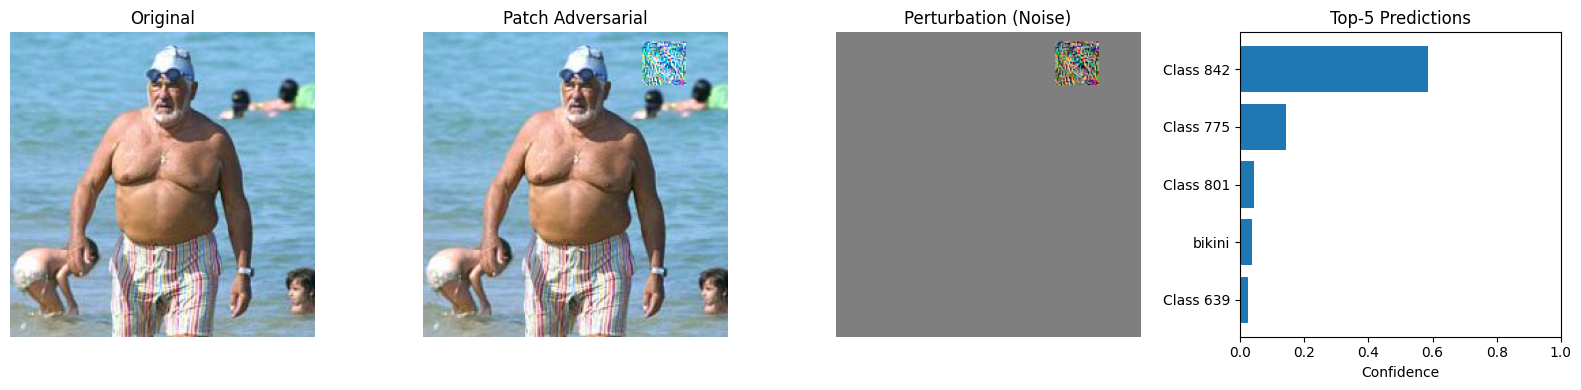

True: bathing cap → Predicted: Band Aid


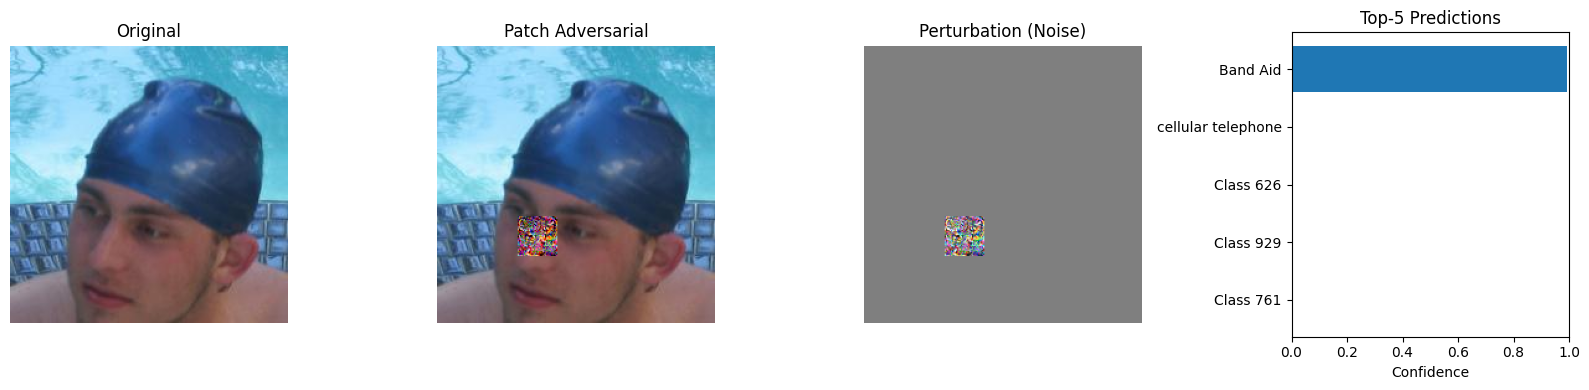

True: bathing cap → Predicted: Class 643


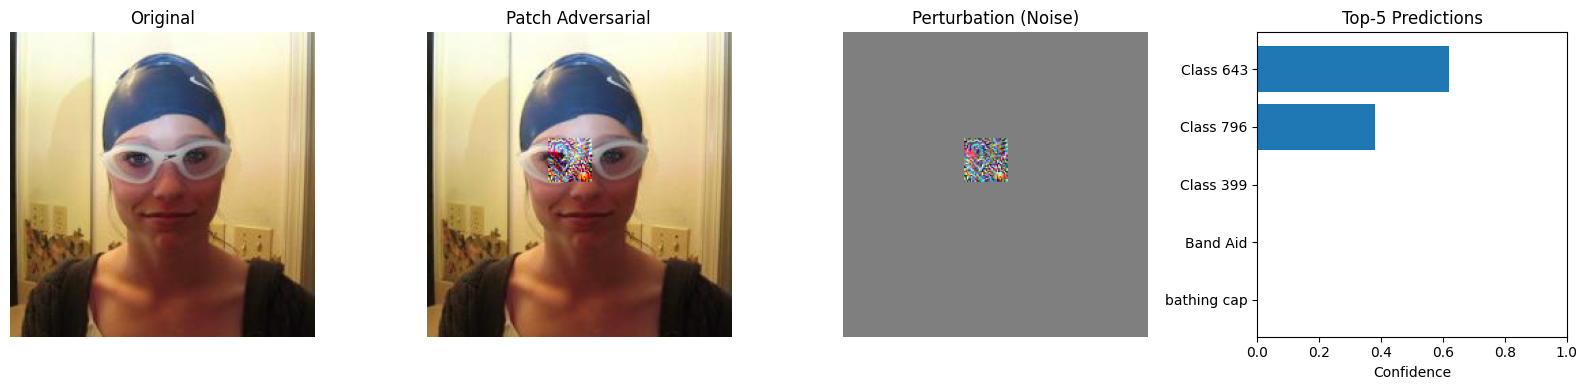

True: bathing cap → Predicted: bikini


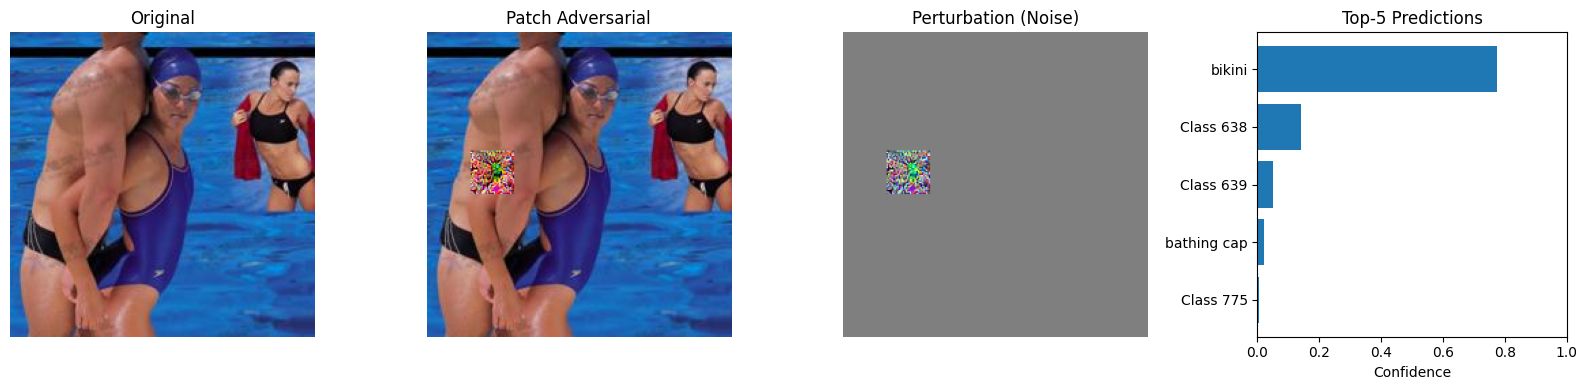

True: bathing cap → Predicted: Class 693


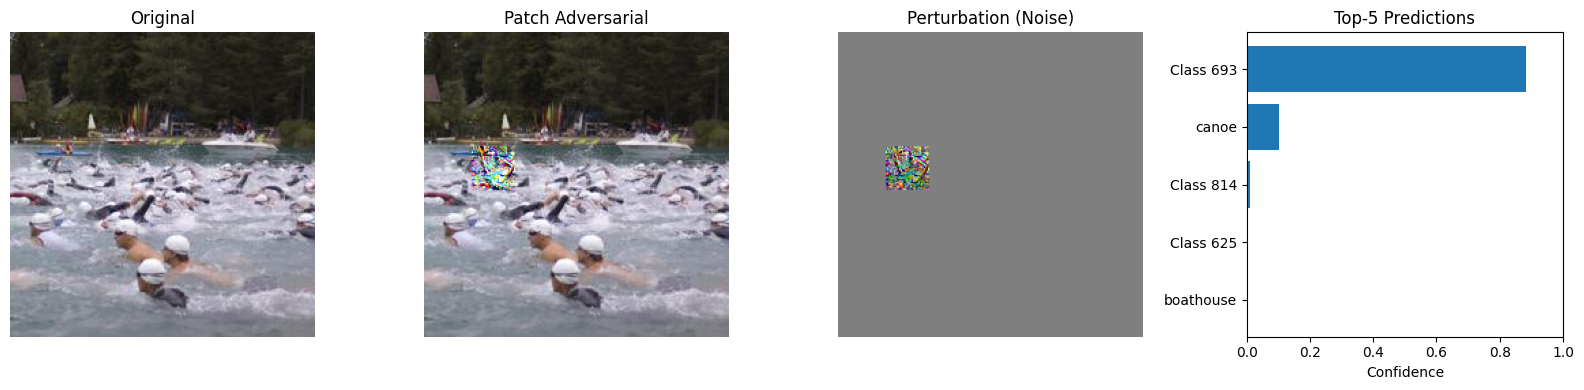

In [13]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

shown = 0
max_to_show = 5
skip_batches = 5

for batch_num, (images, labels) in enumerate(test_loader):
    if batch_num < skip_batches:
        continue

    images, labels = images.to(device), labels.to(device)
    pixel_images = to_pixel_space(images, mean_vals, std_vals).clone().detach()
    B, C, H, W = pixel_images.shape

    # Random patch location per image
    x_starts = torch.randint(0, H - patch_size, (B,))
    y_starts = torch.randint(0, W - patch_size, (B,))

    adv = pixel_images.clone().detach().requires_grad_(True)

    for step in range(patch_steps):
        outputs = model(to_normalized_space(adv, mean_vals, std_vals).float())
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = adv.grad.data
        perturb = torch.zeros_like(adv)

        for b in range(B):
            x, y = x_starts[b], y_starts[b]
            patch_grad = grad[b, :, x:x+patch_size, y:y+patch_size].sign()
            perturb[b, :, x:x+patch_size, y:y+patch_size] = patch_alpha * patch_grad

        adv = adv + perturb
        adv = torch.max(torch.min(adv, pixel_images + patch_eps), pixel_images - patch_eps)
        adv = torch.clamp(adv, 0, 1).detach().requires_grad_(True)

    adv_norm = to_normalized_space(adv, mean_vals, std_vals).float()
    with torch.no_grad():
        preds = model(adv_norm).argmax(dim=1)

    for i in range(images.size(0)):
        if preds[i].item() != labels[i].item():
            noise = (adv[i].detach() - pixel_images[i]).cpu()
            noise = (noise - noise.min()) / (noise.max() - noise.min())
            noise_img = noise.permute(1, 2, 0)

            prob = F.softmax(model(adv_norm[i].unsqueeze(0)), dim=1)[0]
            top5_vals, top5_idxs = torch.topk(prob, 5)
            top5_probs = top5_vals.detach().cpu().numpy()  # ✅ FIXED
            top5_labels = [
                class_names[idx.item() - 401] if 401 <= idx.item() <= 500 else f"Class {idx.item()}"
                for idx in top5_idxs
            ]

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(pixel_images[i].detach().cpu().permute(1, 2, 0))
            axes[0].set_title("Original")
            axes[0].axis('off')

            axes[1].imshow(adv[i].detach().cpu().permute(1, 2, 0))
            axes[1].set_title("Patch Adversarial")
            axes[1].axis('off')

            axes[2].imshow(noise_img)
            axes[2].set_title("Perturbation (Noise)")
            axes[2].axis('off')

            axes[3].barh(top5_labels[::-1], top5_probs[::-1])
            axes[3].set_xlim(0, 1)
            axes[3].set_title("Top-5 Predictions")
            axes[3].set_xlabel("Confidence")

            true_id = labels[i].item()
            pred_id = preds[i].item()
            true_label = class_names[true_id - 401] if 401 <= true_id <= 500 else f"Class {true_id}"
            pred_label = class_names[pred_id - 401] if 401 <= pred_id <= 500 else f"Class {pred_id}"
            print(f"True: {true_label} → Predicted: {pred_label}")

            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= max_to_show:
                break
    if shown >= max_to_show:
        break



**Task 5**

**Transferability ResultsWe tested how well adversarial examples generated for ResNet-34 transfer to DenseNet-121. The results show that while the original clean dataset is classified with high accuracy, all three attack variants significantly degrade performance on DenseNet-121 as well, especially PGD. This confirms that adversarial perturbations can generalize across model architectures.Mitigation idea: Training models with adversarial examples from other architectures or ensembles can help reduce transferability.**


In [14]:
from torchvision.models import densenet121

# Load alternate model
densenet = densenet121(weights='IMAGENET1K_V1').to(device)
densenet.eval()

# Generic evaluation function
def evaluate_transfer(loader, model, name):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            top1, top5 = topk_accuracy(outputs, labels, topk=(1, 5))
            top1_correct += top1
            top5_correct += top5
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total

    print(f"📊 {name} Accuracy on DenseNet-121:")
    print(f"   ➤ Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"   ➤ Top-5 Accuracy: {top5_acc:.2f}%")
    print("")
    return top1_acc, top5_acc

# Run Task 5 evaluations
print("== ✅ Task 5: Transferability to DenseNet-121 ==\n")

clean_top1, clean_top5 = evaluate_transfer(test_loader, densenet, "Clean Test Set")
fgsm_top1, fgsm_top5 = evaluate_transfer(adv_loader, densenet, "FGSM (Adversarial Test Set 1)")
pgd_top1, pgd_top5 = evaluate_transfer(adv_loader_pgd, densenet, "PGD (Adversarial Test Set 2)")
patch_top1, patch_top5 = evaluate_transfer(adv_loader_patch, densenet, "Patch (Adversarial Test Set 3)")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s] 


== ✅ Task 5: Transferability to DenseNet-121 ==

📊 Clean Test Set Accuracy on DenseNet-121:
   ➤ Top-1 Accuracy: 74.80%
   ➤ Top-5 Accuracy: 93.60%

📊 FGSM (Adversarial Test Set 1) Accuracy on DenseNet-121:
   ➤ Top-1 Accuracy: 45.80%
   ➤ Top-5 Accuracy: 76.20%

📊 PGD (Adversarial Test Set 2) Accuracy on DenseNet-121:
   ➤ Top-1 Accuracy: 39.80%
   ➤ Top-5 Accuracy: 76.60%

📊 Patch (Adversarial Test Set 3) Accuracy on DenseNet-121:
   ➤ Top-1 Accuracy: 69.40%
   ➤ Top-5 Accuracy: 89.60%

